<a href="https://colab.research.google.com/github/gpapadok/gan-pytorch-mnist/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [34]:
# PARAMETERS
LR = .0002
BETA1 = .5
BETA2 = .999
BATCH_SIZE = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5,), (.5,))
     ])

try:
  trainset = torchvision.datasets.MNIST('./data', transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
except RuntimeError:
  trainset = torchvision.datasets.MNIST('./data', download=True, transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [36]:
# print(trainset)
# print(testset)

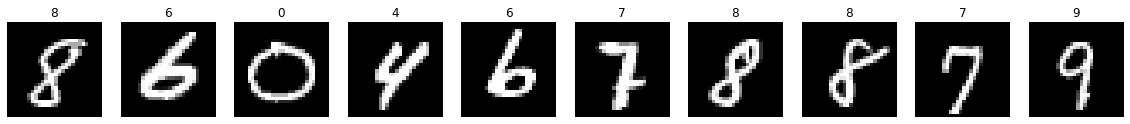

In [37]:
def plot_digits(dataset):
  torch.manual_seed(7096)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [38]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.lin1 = nn.Linear(100+10, 256)
    self.lin2 = nn.Linear(256, 512)
    self.lin3 = nn.Linear(512, 1024)
    self.lin4 = nn.Linear(1024, 784)
    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input, labels):
    labels = self.embedding(labels)
    x = torch.cat([input, labels], dim=1)
    x = self.leaky_relu(self.lin1(x))
    x = self.leaky_relu(self.lin2(x))
    x = self.leaky_relu(self.lin3(x))
    x = self.leaky_relu(self.lin4(x))
    return torch.tanh(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.embedding = nn.Embedding(10, 10)

    self.lin1 = nn.Linear(784+10, 1024)
    self.lin2 = nn.Linear(1024, 512)
    self.lin3 = nn.Linear(512, 256)
    self.lin4 = nn.Linear(256, 1)
    self.leaky_relu = nn.LeakyReLU(.2)
    self.dropout = nn.Dropout(.3)

  def forward(self, input, labels):
    labels = self.embedding(labels)
    x = input.view(-1, 784)
    x = torch.cat([x, labels], dim=1)
    x = self.leaky_relu(self.lin1(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin2(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin3(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.lin4(x))
    return torch.sigmoid(x)

In [39]:
class GAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch, labels):
    return self.generator(batch, labels)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)
    fake = self.generate_fake(noise, labels).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs=EPOCHS, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_history = []
    try:
      for epoch in range(epochs):
        if epoch % 5 == 0:
          self.plot_ten_samples()
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          for _ in range(1):
            self.optimD.zero_grad()

            # Train with real
            real, real_target = data[0].to(device), data[1].to(device)
            batch_size = real.size()[0]
            real_labels = torch.ones(batch_size, 1, device=device) * .9
            out = self.discriminator(real, real_target)
            errD_real = self.loss(out, real_labels)
            errD_real.backward()

            # Train with fake
            noise = torch.randn(batch_size, 100, device=device)
            fake_target = torch.randint(0, 10, (batch_size,), device=device)
            fake = self.generate_fake(noise, fake_target)
            fake_labels = torch.ones(batch_size, 1, device=device) * .1
            out = self.discriminator(fake, fake_target)
            errD_fake = self.loss(out, fake_labels)
            errD_fake.backward()

            self.optimD.step()

          errD_history += [errD_real+errD_fake]

          # TRAIN GENERATOR
          self.optimG.zero_grad()

          noise = torch.randn(batch_size, 100, device=device)
          fake_target = torch.randint(0, 10, (batch_size,), device=device)
          fake = self.generate_fake(noise, fake_target)
          fake_labels = torch.ones(batch_size, 1, device=device)
          out = self.discriminator(fake, fake_target)
          errG = self.loss(out, fake_labels)
          errG.backward()

          self.optimG.step()

          errG_history += [errG]

        print(f'EPOCH {epoch+1:2}: Dloss {errD_history[-1]:.4f} Gloss {errG_history[-1]:.4f}')
    except KeyboardInterrupt:
      return errG_history, errD_history


          
    return errG_history, errD_history

In [40]:
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [41]:
loss = nn.BCELoss()
optimizerD = optim.Adam(dnet.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizerG = optim.Adam(gnet.parameters(), lr=LR, betas=(BETA1, BETA2))

gan = GAN(gnet, dnet, loss, optimizerG, optimizerD)

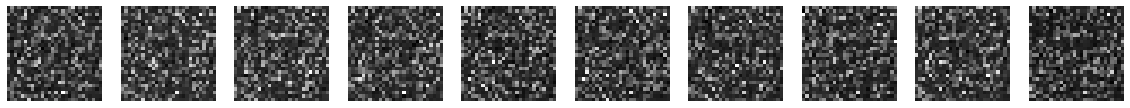

EPOCH  1: Dloss 0.6792 Gloss 2.4476
EPOCH  2: Dloss 0.6631 Gloss 2.7534
EPOCH  3: Dloss 0.6544 Gloss 2.4267
EPOCH  4: Dloss 0.6536 Gloss 2.1774
EPOCH  5: Dloss 0.6522 Gloss 2.3448


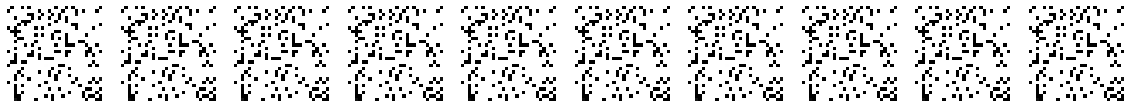

EPOCH  6: Dloss 0.6524 Gloss 2.2838
EPOCH  7: Dloss 0.6521 Gloss 2.3423
EPOCH  8: Dloss 0.6521 Gloss 2.2438
EPOCH  9: Dloss 0.6523 Gloss 2.2351
EPOCH 10: Dloss 0.6523 Gloss 2.2488


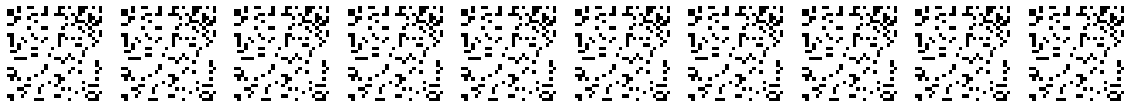

EPOCH 11: Dloss 0.6519 Gloss 2.3805
EPOCH 12: Dloss 0.6523 Gloss 2.3077
EPOCH 13: Dloss 0.6524 Gloss 2.3260
EPOCH 14: Dloss 0.6528 Gloss 2.2298
EPOCH 15: Dloss 0.6522 Gloss 2.1865


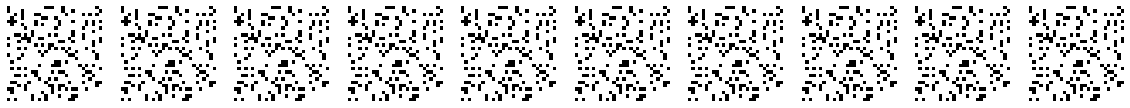

EPOCH 16: Dloss 0.6541 Gloss 2.4717
EPOCH 17: Dloss 0.6518 Gloss 2.2465
EPOCH 18: Dloss 0.6526 Gloss 2.3401
EPOCH 19: Dloss 0.6524 Gloss 2.4662
EPOCH 20: Dloss 0.6519 Gloss 2.3264


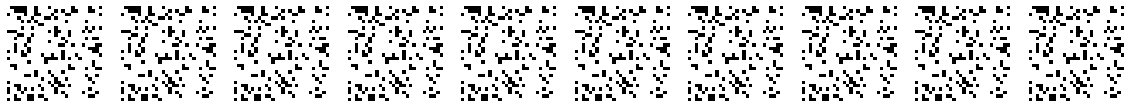

EPOCH 21: Dloss 0.6528 Gloss 2.1943
EPOCH 22: Dloss 0.6521 Gloss 2.3778
EPOCH 23: Dloss 0.6523 Gloss 2.3558


In [ ]:
errorG_history, errorD_history = gan.train(trainset, epochs=80)

In [ ]:
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()

In [ ]:
plt.plot(errorG_history)
plt.plot(errorD_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['generator','discriminator'])

In [ ]:
torch.save(gan.generator.state_dict(), "cgan.pt")